<a href="https://colab.research.google.com/github/rmedi21/challenge-telecom-x-2/blob/main/TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracción

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [ ]:
# CARGAR BASE DE DATOS
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"

response = requests.get(url)

if (response.status_code == 200):
    data = response.json()
    df = pd.json_normalize(data)
else:
    print('Error al obtener pagina.')

#🔧 Transformación

In [ ]:
# LIMPIAR NOMBRES DE COLUMNAS
nuevos_nombres = []

for nombre in df.columns:
    idx = nombre.find('.')
    nuevo_nombre = ""

    if idx == -1:
        nuevo_nombre = nombre
    else:
        nuevo_nombre = nombre[idx+1:]

    if nuevo_nombre[0].islower():
        nuevo_nombre = nuevo_nombre[0].upper() + nuevo_nombre[1:]

    nuevos_nombres.append(nuevo_nombre)

df.columns = nuevos_nombres

In [ ]:
# CAMBIAR NOMBRES DE VARIABLES
df.rename(columns={'Gender': 'Sexo_Biologico',
                   'SeniorCitizen': 'Tiene_Tercera_Edad',
                   'Contract': 'Tipo_Contrato',
                   'Partner': 'Tiene_Pareja',
                   'Dependents': 'Tiene_Dependientes',
                   'PhoneService': 'Tiene_Telefonia',
                   'Tenure': 'Meses_Contrato',
                   'MultipleLines': 'Tiene_Multiples_Lineas',
                   'InternetService': 'Servicio_Internet',
                   'PaymentMethod': 'Metodo_Pago',
                   'Charges.Monthly': 'Cuentas_Mensual',
                   'Charges.Total': 'Cuentas_Total'}, inplace=True)

In [ ]:
# ELIMINAR COLUMNA CODIGO
df.drop('CustomerID', axis=1, inplace=True)

In [ ]:
# IDENTIFICAR REGISTROS SIN TARGET (Churn)
df['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869
,224


In [ ]:
# BORRAR REGISTROS SIN TARGET
filtro = df[df['Churn']==""].index
df.drop(filtro, axis=0, inplace=True)

In [ ]:
# IDENTIFICAR DUPLICADOS (sin contar CustomerID)
df_duplicados = df[df.duplicated()]
len(df_duplicados)

22

In [ ]:
# ELIMINAR DUPLICADOS
filtro = df_duplicados.index
df.drop(filtro, axis=0, inplace=True)

In [ ]:
# VALIDAR MONTOS
df[['Cuentas_Mensual', 'Cuentas_Total']].sum()

,0
Cuentas_Mensual,455325.15
Cuentas_Total,593.3542.4280.851237.85267.4571.457904.255377....


In [ ]:
# CORREGIR 'Cuentas_Total'
# Identificar vacios
len(df[df['Cuentas_Total'].str.strip() == ""])

11

In [ ]:
# Imputar monto:
#   Si Meses_Contrato = 0: Cuentas_Mensual
#   Si Meses_Contrato > 0: Meses_Contrato * Cuentas_Mensual
filtro = df[df['Cuentas_Total'].str.strip() == ""].index
df.loc[filtro, 'Cuentas_Total'] = df.apply(
                                      lambda x: x['Cuentas_Mensual'] if x['Meses_Contrato'] == 0 \
                                                else x['Meses_Contrato'] * x['Cuentas_Mensual'],
                                      axis=1
                                  )

In [ ]:
# Ajustar tipo de dato
df['Cuentas_Total'] = df['Cuentas_Total'].astype(float)

In [ ]:
# HOMOLOGAR VALORES
# OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
#   Si Servicio_Internet = No -> replace('No internet service', 'No')
filtro = df[df['Servicio_Internet'] == 'No'].index
df.loc[filtro, df.columns[9:15]] = 'No'

# Tiene_Multiples_Lineas
#   Si Tiene_Telefonia = No -> replace('No phone service', 'No')
filtro = df[df['Tiene_Telefonia'] == 'No'].index
df.loc[filtro, 'Tiene_Multiples_Lineas'] = 'No'

In [ ]:
# TRANSFORMAR VARIABLES BINARIAS
# Gender, Partner, Dependents, PhoneService, MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport,
# StreamingTV, StreamingMovies, PaperlessBilling
cols = ['Churn', 'Sexo_Biologico', 'Tiene_Pareja', 'Tiene_Dependientes', 'Tiene_Telefonia', 'Tiene_Multiples_Lineas',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
        'PaperlessBilling']
df[cols] = df[cols].replace({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

/tmp/ipython-input-3078192350.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols] = df[cols].replace({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})


In [ ]:
# CREAR COLUMNAS
# Cuentas_Diarias: Cuentas_Mensual / 30
df['Cuentas_Diarias'] = round(df['Cuentas_Mensual'] / 30, 2)

# Tiene_Internet: Servicio_Internet in ('DSL', 'Fiber optic') -> 1, 'No' -> 0
df['Tiene_Internet'] = df['Servicio_Internet'].apply(lambda x: 0 if x == 'No' else 1)

# Numero de servicios contratados
df['Nro_Servicios'] = df['Tiene_Telefonia'] + df['Tiene_Multiples_Lineas'] + df['Tiene_Internet'] + \
                      df['OnlineSecurity'] + df['OnlineBackup'] + df['DeviceProtection'] + df['TechSupport'] + \
                      df['StreamingTV']  + df['StreamingMovies']

In [ ]:
# EXPORTAR DATOS
df.to_csv('TelecomX_Data_Depurada.csv', index=False)

#📊 Carga y análisis

In [ ]:
# ESTILO DE GRAFICOS
sns.set_palette("tab10")

In [ ]:
# FUNCIONES
def ancho_bin(df, columna):
    q1, q3 = np.percentile(df[columna], [25, 75])
    iqr = q3 - q1
    ancho = 2 * iqr * np.power(len(df[columna]), -1/3)
    return ancho

In [ ]:
# ANALISIS DESCRIPTIVO
# Variables Numericas
df[['Meses_Contrato','Nro_Servicios','Cuentas_Diarias','Cuentas_Mensual','Cuentas_Total']].describe().round(1)

,Meses_Contrato,Nro_Servicios,Cuentas_Diarias,Cuentas_Mensual,Cuentas_Total
count,7021.0,7021.0,7021.0,7021.0,7021.0
mean,32.5,4.2,2.2,64.9,2286.8
std,24.5,2.3,1.0,30.1,2266.8
min,0.0,1.0,0.6,18.2,18.8
25%,9.0,2.0,1.2,35.8,403.4
50%,29.0,4.0,2.4,70.4,1400.6
75%,55.0,6.0,3.0,89.9,3801.7
max,72.0,9.0,4.0,118.8,8684.8


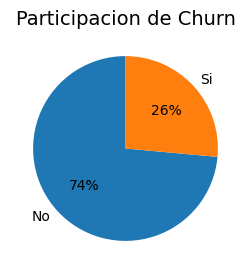

In [ ]:
# Participacion de Churn: 26% fuga, 74% permanece
plt.figure(figsize=(4, 3))
plt.pie(df['Churn'].value_counts(), labels=['No','Si'], autopct='%1.0f%%', startangle=90)
plt.title('Participacion de Churn', fontsize=14)

plt.show()
# plt.savefig("participacion_churn.png", bbox_inches='tight', dpi=300)
# plt.close()

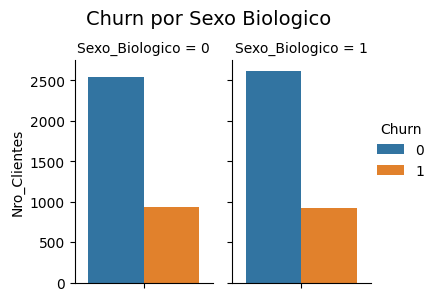

In [ ]:
# Churn por Sexo: se mantiene la distribucion en ambos sexos
df2 = df.groupby(['Churn', 'Sexo_Biologico'])['Churn'].count()
df2 = df2.reset_index(name='Nro_Clientes')

ax = sns.catplot(
        data=df2, hue="Churn", y="Nro_Clientes", col="Sexo_Biologico",
        kind="bar", height=2.8, aspect=.7
     )

ax.fig.suptitle("Churn por Sexo Biologico", y=1.06, fontsize=14)

plt.show()
# plt.savefig("distribucion_churn_sexo.png", bbox_inches='tight', dpi=300)
# plt.close()

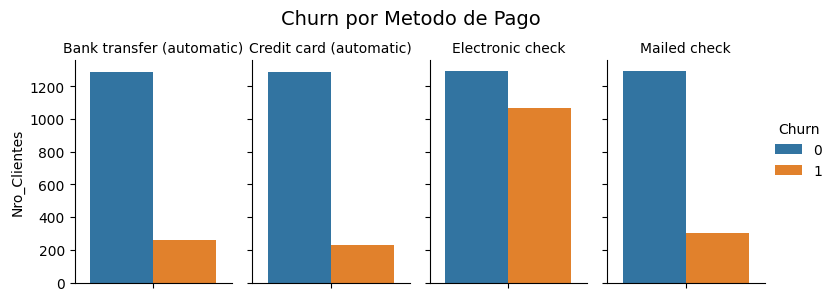

In [ ]:
# Churn por Metodo de pago: el cheque electronico tiene mayor fuga que los otros tipos de pago
df2 = df.groupby(['Churn', 'Metodo_Pago'])['Churn'].count()
df2 = df2.reset_index(name='Nro_Clientes')

ax = sns.catplot(
        data=df2, hue="Churn", y="Nro_Clientes", col="Metodo_Pago",
        kind="bar", height=2.8, aspect=.7
     )

ax.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
ax.fig.suptitle("Churn por Metodo de Pago", y=1.06, fontsize=14)

plt.show()
# plt.savefig("distribucion_churn_metodo_pago.png", bbox_inches='tight', dpi=300)
# plt.close()

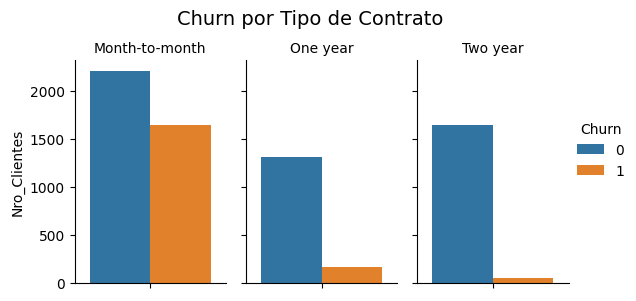

In [ ]:
# Churn por Tipo de contrato: el contrato mensual tiene mayor fuga que los otros tipos
df2 = df.groupby(['Churn', 'Tipo_Contrato'])['Churn'].count()
df2 = df2.reset_index(name='Nro_Clientes')

ax = sns.catplot(
        data=df2, hue="Churn", y="Nro_Clientes", col="Tipo_Contrato",
        kind="bar", height=2.8, aspect=.7,
     )

ax.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
ax.fig.suptitle("Churn por Tipo de Contrato", y=1.06, fontsize=14)

plt.show()
# plt.savefig("distribucion_churn_tipo_contrato.png", bbox_inches='tight', dpi=300)
# plt.close()

/tmp/ipython-input-3119203289.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45, ha='right')


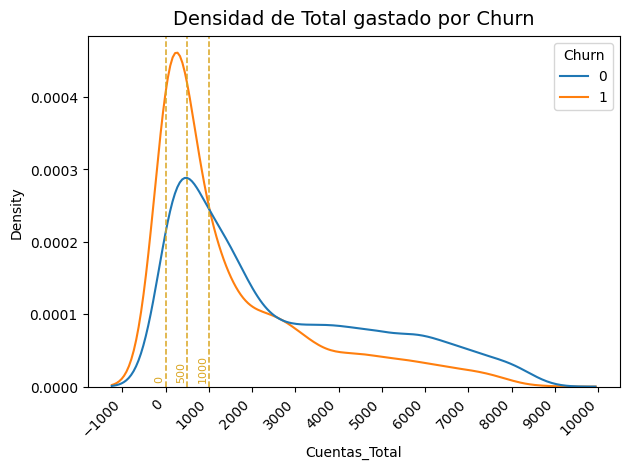

In [ ]:
# Distribucion de Total gastado por Churn:
# -Clientes fugados y que permanecen tienen distribucion semejante:
#   -Alta concentracion de clientes con gastos bajos
#   -A medida que aumenta el gasto disminuye la cantidad de clientes
ax = sns.kdeplot(data=df, x="Cuentas_Total", hue="Churn", common_norm=False)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45, ha='right')
plt.axvline(x=0, linewidth=1.1, color='goldenrod', linestyle='--', label="0")
plt.axvline(x=500, linewidth=1.1, color='goldenrod', linestyle='--')
plt.axvline(x=1000, linewidth=1.1, color='goldenrod', linestyle='--')
plt.text(-20, 9E-6, '0', fontsize=8, color='goldenrod', ha='right', rotation=90)
plt.text(480, 9E-6, '500', fontsize=8, color='goldenrod', ha='right', rotation=90)
plt.text(980, 9E-6, '1000', fontsize=8, color='goldenrod', ha='right', rotation=90)
plt.title("Densidad de Total gastado por Churn", y=1.01, fontsize=14)
plt.tight_layout()

plt.show()
# plt.savefig("densidad_cuenta_total_churn.png", bbox_inches='tight', dpi=300)
# plt.close()

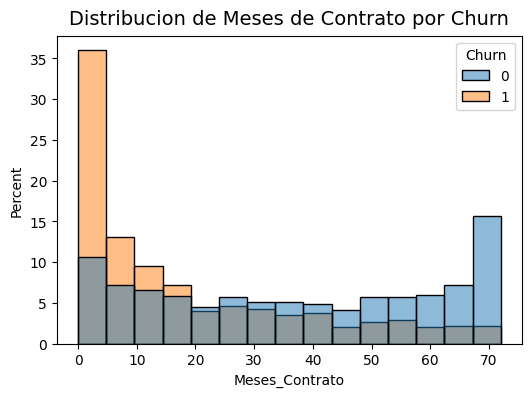

In [ ]:
# Distribucion de Meses de Contrato por Churn:
# -Los clientes que fugan tienen menos meses de contrato
# -A medida que aumentan los meses de contrato mas clientes permanecen
anchobin = ancho_bin(df, 'Meses_Contrato')

fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df, x="Meses_Contrato", hue="Churn",
    stat="percent", binwidth=anchobin, common_norm=False,
    ax=ax
)

plt.title("Distribucion de Meses de Contrato por Churn", y=1.01, fontsize=14)

plt.show()
# plt.savefig("distribucion_meses_contrato_churn.png", bbox_inches='tight', dpi=300)
# plt.close()

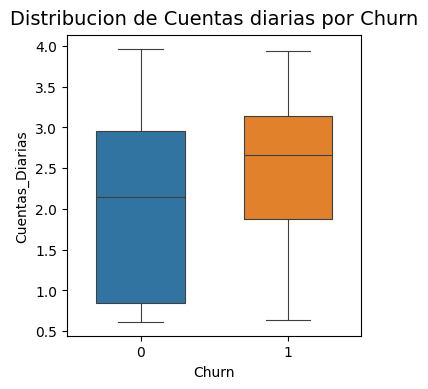

In [ ]:
# Distribucion de Cuentas diarias por Churn:
# -Los clientes que permanecen están más dispersos que los clientes fugados
# -Los clientes fugados tienen asimetria negativa: la mayoria de los montos diarios son altos
# -Los clientes fugados tienen mediana mas alta:
#   -El 50% de clientes fugados tienen montos diarios > 2.7, mientras los clientes que permanecen > 2.2
fig, ax = plt.subplots(figsize=(3.8, 3.9))

sns.boxplot(
    data=df, x='Churn', y='Cuentas_Diarias', hue='Churn',
    width=.6, linewidth=.8,
    ax=ax
)

plt.title("Distribucion de Cuentas diarias por Churn",  y=1.01, fontsize=14)
ax.legend().set_visible(False)
ax.grid(False)

plt.show()
# plt.savefig("boxplot_cuentas_diarias_churn.png", bbox_inches='tight', dpi=300)
# plt.close()

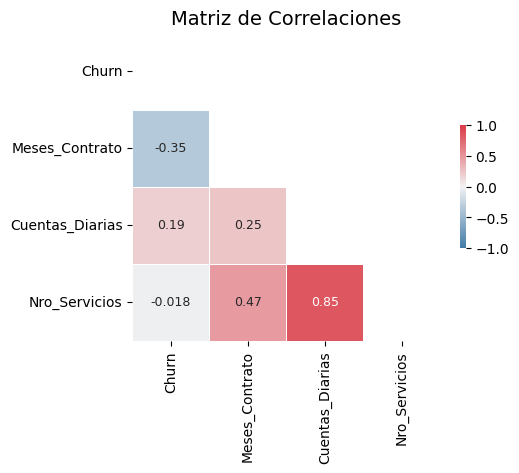

In [ ]:
# Matriz de Correlaciones:
# -La correlacion entre el Churn y los Meses de contrato es negativa y moderada
# -La correlacion entre el Churn y las Cuentas diarias es positiva y debil
# -La correlacion entre el Churn y el Numero de servicio es es nula
cols = ['Churn', 'Meses_Contrato', 'Cuentas_Diarias', 'Nro_Servicios']
corr = df[cols].corr()

mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

fig, ax = plt.subplots(figsize=(5, 4))
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.heatmap(
        corr, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0, square=True,
        linewidths=.5, annot=True,
        cbar_kws={"shrink": .4}, annot_kws={'size': 9}
    )

plt.title("Matriz de Correlaciones",  y=1.0, fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# plt.savefig("matriz_correlaciones.png", bbox_inches='tight', dpi=300)
# plt.close()
plt.show()

#📄Informe final

## Introducción
La empresa enfrenta una alta tasa de cancelaciones y necesita comprender los factores que llevan a la pérdida de clientes.

El objetivo de este proyecto es recopilar, procesar y analizar los datos para extraer información valiosa. A partir de este análisis, el equipo de Data Science podrá avanzar en modelos predictivos y desarrollar estrategias para reducir la evasión.
<br/><br/>
## Limpieza y Tratamiento de Datos
Se procedió a importar la data en formato json utilizando la librería **requests** y dando formato tabla con la funcion *json_normalize* de libreria **pandas**.
```
response = requests.get(url)

if (response.status_code == 200):
    data = response.json()
    df = pd.json_normalize(data)
else:
    print('Error al obtener pagina.')
```
Los campos al estar anidados, se encuentran en el formato *campo.campo_anidado.campo_anidado*, por ello se utilizó una función para formatear los nombres:
```
nuevos_nombres = []

for nombre in df.columns:
    idx = nombre.find('.')
    nuevo_nombre = ""

    if idx == -1:
        nuevo_nombre = nombre
    else:
        nuevo_nombre = nombre[idx+1:]

    if nuevo_nombre[0].islower():
        nuevo_nombre = nuevo_nombre[0].upper() + nuevo_nombre[1:]

    nuevos_nombres.append(nuevo_nombre)

df.columns = nuevos_nombres
```
En lo que respecta a la limpieza de los datos, se realizaron las siguientes acciones:
* Eliminar columna código de cliente (*CustomerID*)
* Eliminar registros sin target (*Churn* con valor vacío [''])
* Identificar y eliminar registros duplicadas
* Corregir monto total:
 + Ajustar tipo de dato a *float*
 + Imputar monto total con valores vacíos
* Homologar valores:
 + No internet service -> No
 + No phone service -> No
* Transformar variables binarias: Si = 1, No = 0
* Crear columnas:
 + Cuentas_Diarias = Cuentas_Mensual / 30
 + Tiene_Internet = Servicio_Internet in ('DSL', 'Fiber optic') -> 1, Servicio_Internet = 'No' -> 0
 + Nro_Servicios = Numero de servicios contratados

<br/>

## Análisis Exploratorio de Datos
Una vez la base de datos se encuentra limpia y formateada, procedemos con el análisis descriptivo.
<br/>
* **Variable Objetivo**<br/>
La variable objetivo (*Churn*) muestra una participación de 26% en clientes fugados y 74% en clientes que permanecen, es decir, de cada 4 clientes 1 es fugado.<br/>
<img alt='Participacion de churn' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/participacion_churn.png'  width="300" height="315" />
<br/><br/>
* **Variables categóricas**<br/>
Se observa que el Churn por sexo biológico muestra igual proporción de clientes en ambos sexos:
<img alt='Distibucion de churn por sexo' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/distribucion_churn_sexo.png' width="450" height="315" />
<br/><br/>
Si analizamos por Método de pago, se observa que el cheque electrónico tiene mayor fuga que los otros métodos de pago, que presentan distribución en similar proporción:
<img alt='Distibucion de churn por metodo pago' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/distribucion_churn_metodo_pago.png' width="800" height="315" />
<br/><br/>
En el análisis por Tipo de contrato el contrato mensual tiene mayor fuga que los otros tipos:
<img alt='Distibucion de churn por tipo contrato' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/distribucion_churn_tipo_contrato.png' width="620" height="315" />
<br/><br/>
* **Variables numéricas**<br/>
Analizamos la distribucion del Total gastado por Churn utilizando un gráfico de densidad. Se observa que ambas distribuciones son semejantes:<br/>
    -Alta concentracion de clientes con gastos bajos<br/>
    -A medida que aumenta el gasto disminuye la cantidad de clientes
<img alt='Distibucion de total gastado por churn' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/densidad_cuenta_total_churn.png' width="630" height="450" />
<br/><br/>
Si analizamos la distribución de Meses de Contrato por Churn, encontramos que los clientes que fugan tienen menos meses de contrato y que a medida que aumentan los meses mas clientes permanecen:
<img alt='Distibucion de meses de contrato por churn' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/distribucion_meses_contrato_churn.png' width="540" height="400" />
<br/><br/>
Además, si analizamos la distribucion de Cuentas diarias por Churn encontramos lo siguiente:<br/>
    -Los clientes que permanecen están más dispersos que los clientes fugados<br/>
    -Los clientes fugados tienen asimetria negativa: la mayoria de los montos diarios son altos<br/>
    -Los clientes fugados tienen mediana mas alta: el 50% de clientes fugados tienen montos diarios > 2.7, mientras los clientes que permanecen > 2.2<br/>
<img alt='Distibucion de cuentas diarias por churn' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/boxplot_cuentas_diarias_churn.png' width="420" height="370" />
<br/><br/>
* **Correlación de variables**<br/>
Se analizó la correlación de las variables numéricas con la variable objetivo obteniendo lo siguiente:<br/>
    -La correlación entre el Churn y los Meses de contrato es negativa y moderada<br/>
    -La correlación entre el Churn y las Cuentas diarias es positiva y débil<br/>
    -La correlación entre el Churn y el Número de servicio es es nula<br/>
<img alt='Matriz de correlaciones' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/matriz_correlaciones.png' width="450" height="420" />
<br/><br/><br/>

## Conclusiones e Insights
- Se puede observar un comportamiento diferenciado para el Churn por la variable Meses de contrato y Cuentas diarias, según los gráficos analizados.
- Lo anterior se corrobora con la matriz de correlaciones, aunque se muestra una correlación moderada y débil respectivamente.
- Entonces una forma de reducir el Churn es hacer que el cliente se mantenga varios meses con el servicio y que su facturación diaria sea mínima.
<br/><br/><br/>

## Recomendaciones
- Se recomienda balancear los datos debido a que los clientes que permanecen son la clase dominante (la relación es de 3 a 1 con los fugados).
- Se recomienda trabajar el modelo predictivo con las variables analizadas (Sexo_Biologico, Metodo_Pago, Meses_Contrato, Cuentas_Diarias, Numero_Servicios).